# Исследование успешности компьютерных игр

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Откроем датасет и изучим общую информацию

In [1]:
#импортируем все необходимые для работы библиотеки:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
#библиотека для борьбы с warnings:
import warnings
warnings.filterwarnings('ignore')

In [2]:
games_data = pd.read_csv('/datasets/games.csv')
games_data.head(15) #взглянем на общий вид датасета, выведя первые 15 строк

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [3]:
games_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Описание данных**
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

**О данных можно сделать следующие выводы перед предобработкой:**

 - Датасет состоит из 16715 строк и 11 столбцов. 
 - В данных есть пропуски.
 - В некоторых столбцах установлены неверные типы данных: в `Year_of_Release` float вместо int, в `User_Score` object вместо float. 
 - Необходимо привести названия столбцов к нижнему регистру.

### Предобработка данных

In [4]:
games_data.columns = games_data.columns.str.lower() #приводим названия столбцов к нижнему регистру

Посмотрим, в каких столбцах имеются пропуски и сколько их:

In [5]:
games_data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Строки, где пропущены название, год релиза и жанр можно удалить, так как их совсем мало. Также приведем к целому типа год релиза.

In [6]:
games_data = games_data.dropna(subset=['name', 'year_of_release', 'genre'])
games_data['year_of_release'] = games_data['year_of_release'].astype('int')

Теперь разберемся с остальными пропусками. Они остались в столбцах `critic_score`, `user_score` и `rating`. Их слишком много. Но заполнять их по какому-либо принципу, вроде среднего или медианы, нельзя, так как это некорректно. Мы не можем заменить оценки критиков и пользователей, так как они выставляются персонально для каждой игры. Можем только заменить пропуски в рейтинге на "undefined". чтобы это была категория с неопределенным рейтингом. 

In [7]:
games_data['rating'] = games_data['rating'].fillna('undefined')

In [8]:
games_data['rating'].unique() #посмотрим, какие вообще рейтинги есть и все ли они корректны (да, все ок)

array(['E', 'undefined', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

In [9]:
games_data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В оценках пользователей есть значения tbd, видимо, это "to be defined/determined/decided" - будет решено/определено. Стоит заменить эти значения на Nan, так как иначе обработать такие строки будет невозможно. И поменяем тип данных с object на float.

In [10]:
games_data['user_score'] = games_data['user_score'].replace('tbd', np.NaN)
games_data['user_score'] = games_data['user_score'].astype('float')

In [11]:
print(games_data.duplicated().sum()) #удостоверимся, что нет явных дубликатов

0


Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец:

In [12]:
games_data['total_sales'] = games_data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [13]:
games_data.head(10) #теперь датасет выглядит так

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,undefined,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,undefined,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,undefined,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,undefined,28.31


**Итак:**
- исправили названия столбцов, изменив регистр на нижний;
- выяснили, в каких столбцах имеются пропуски, их количество. Удалили строи с пропусками, где их количество было не критичным;
- строки с большим количеством пропусков в столбцах `user_score` и `critic_score` оставили без изменений, так как в данном случае заполнять их медианным или средним значением было бы некорректно.  В столбце `user_score` также были необычные значения 'tbd', данные не были заполнены не случайно, эти значения для возможности дальнейшей обработки заменили на Nan. Пропуски в рейтинге  заменили на 'undefined'(не определено), так как заполнять иначе их также было бы неверно;
- создали новый столбец с суммой продаж по всем регионам.

### Исследовательский анализ данных

#### Посмотрим, сколько игр выпускалось в разные годы.

Text(0, 0.5, 'Количество выпущенных игр')

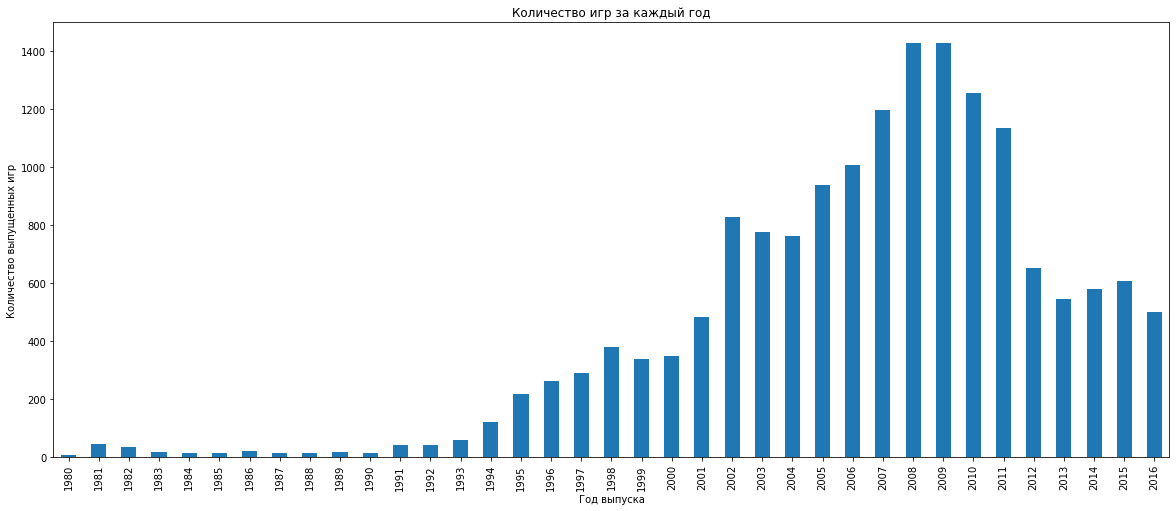

In [14]:
games_in_each_year = games_data.pivot_table(index='year_of_release', values='name', aggfunc='count')
games_in_each_year.plot(kind='bar', figsize=(20,8), legend=False)
plt.title("Количество игр за каждый год")
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")

По полученному графику видно, что до 1994 года количество выпускаемых игр было очень малым. Это связно с тем, что до того времени компьютеры не были мощными, имелись далеко не у каждого человека, не было разнообразных игровых платформ, скорость интернета была по нашим меркам сегодняшним просто никакой. После 94 года количество выпускаемых игр растет, особенно с 2002 по 2011, так как все больше людей имеют компьютеры, появляются новые приставки, скорость интернета растет и качество графики в играх растет. Пик на 2008-2010 годах. Затем количество выпускаемых платформенных игр падает, так как люди переходят на смартфоны. Развиваются уже игры для смартфонов, люди погружаются в социальные сети.

#### Посмотрим теперь, как менялись продажи по платформам.

Сначала посмотрим, какие платформы вообще являются самыми популярными.

Text(0, 0.5, 'Количество продаж')

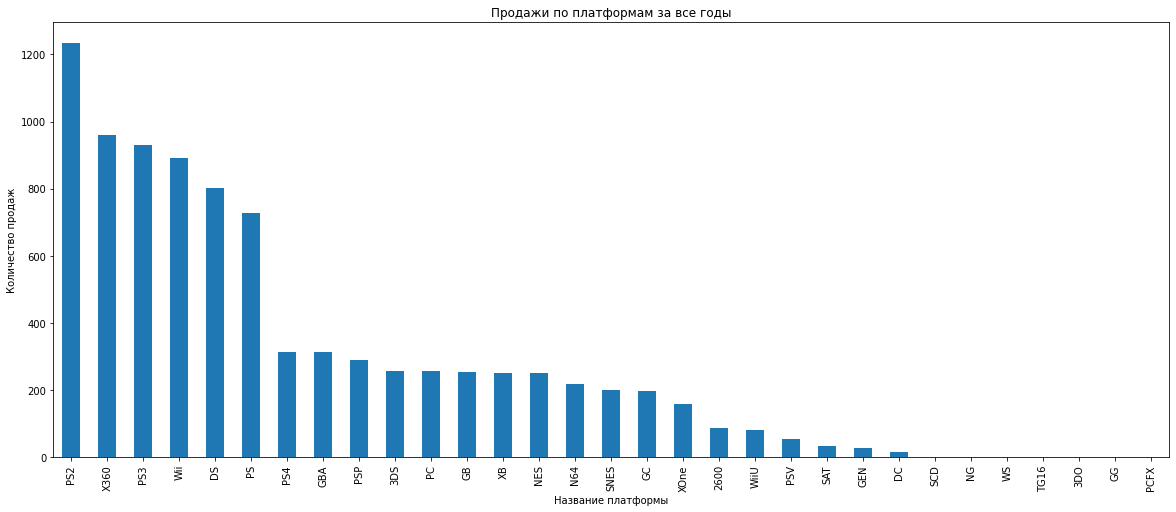

In [15]:
platform_sales = games_data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)

platform_sales.plot(kind='bar', figsize=(20,8), legend=False)
plt.title("Продажи по платформам за все годы")
plt.xlabel("Название платформы")
plt.ylabel("Количество продаж")

Из получившегося графика делаем вывод, что самыми популярные игровые платформы за всё время это: PS2, X360, PS3, Wii, DS и PS. 

In [16]:
platform_sales.sort_values(by='total_sales', ascending=False).head(6)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58


In [17]:
platforms_list = games_data['platform'].unique() #список всех платфом
platforms_list

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

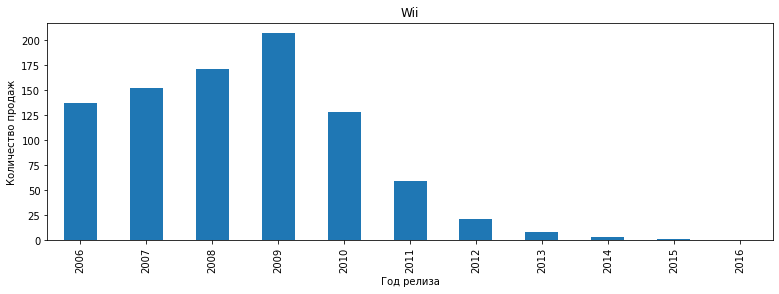

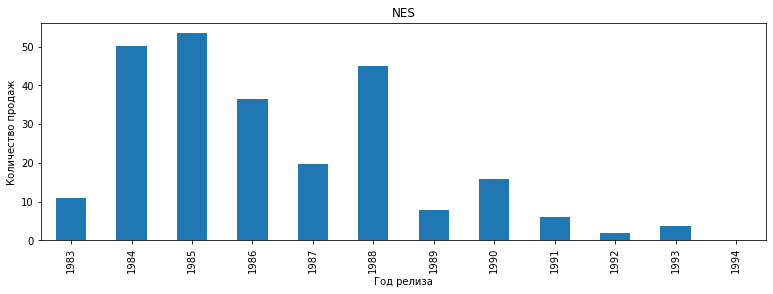

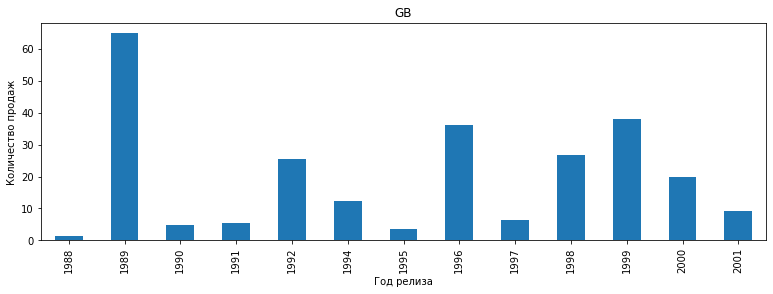

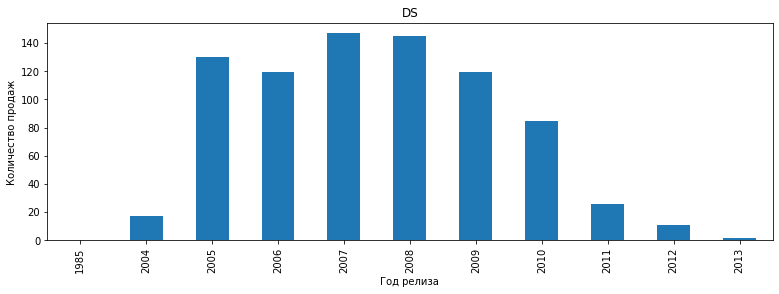

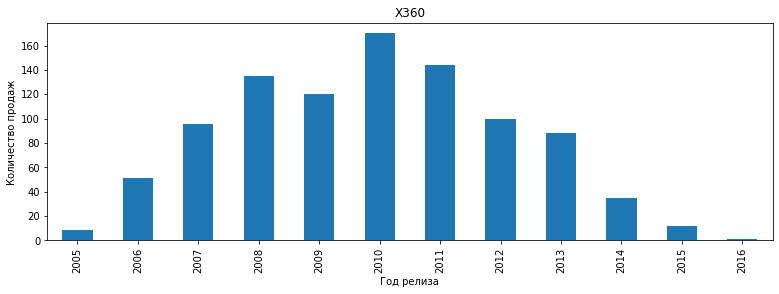

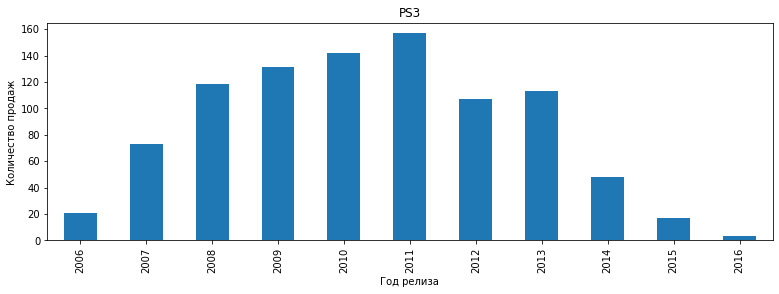

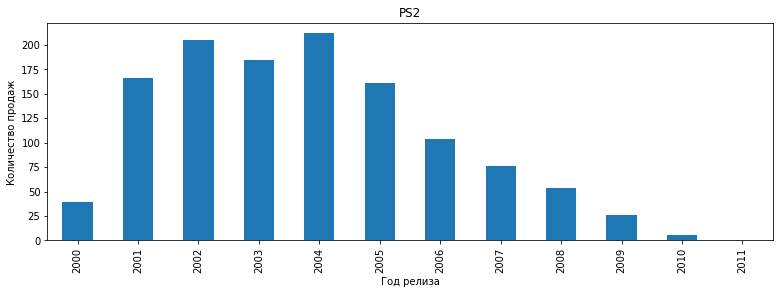

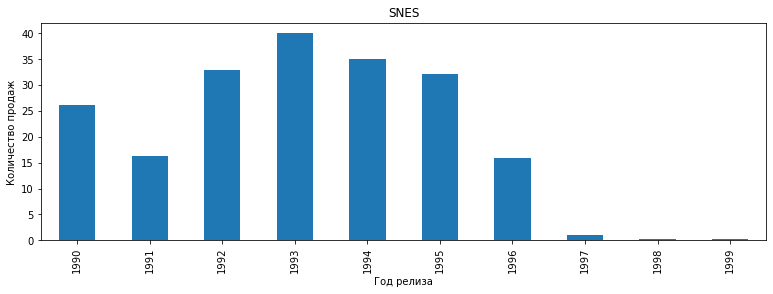

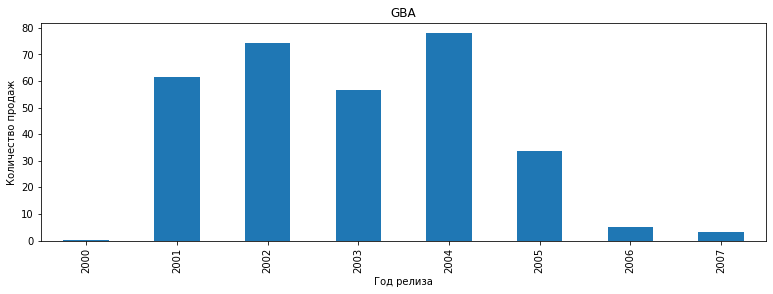

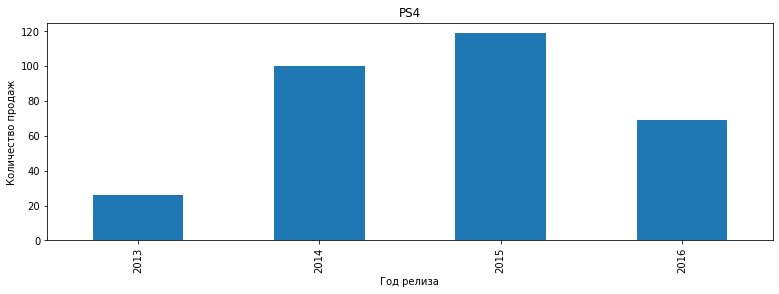

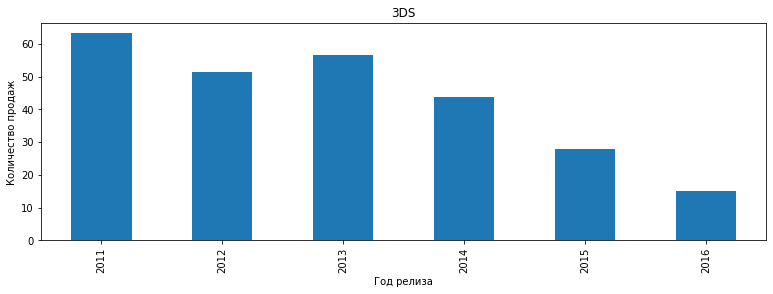

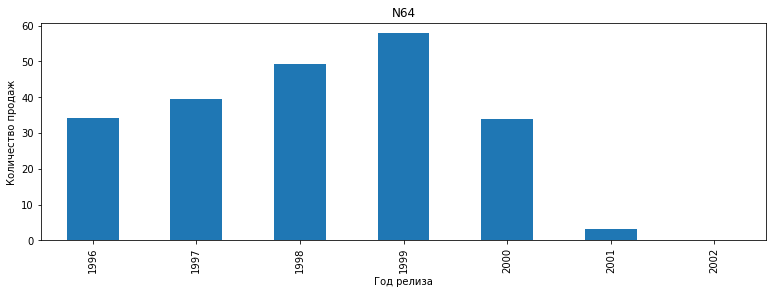

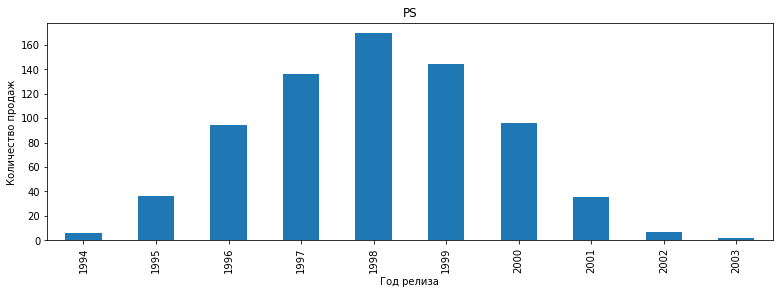

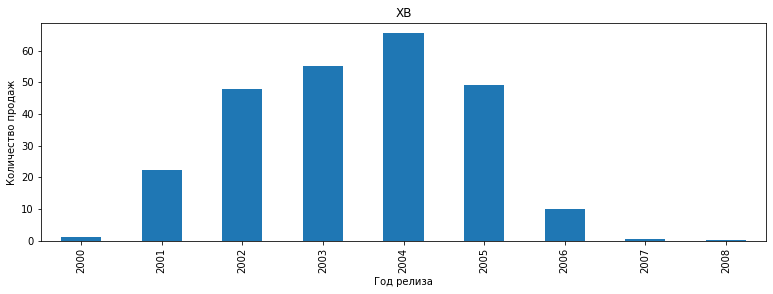

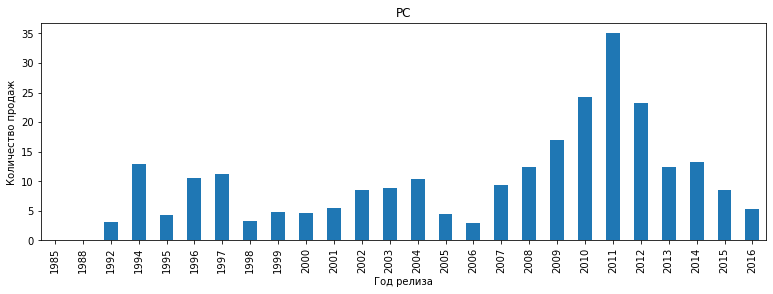

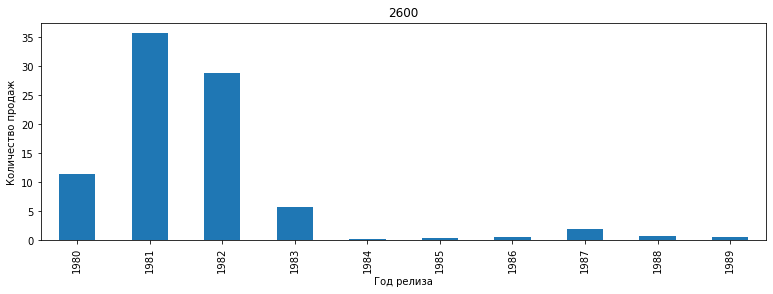

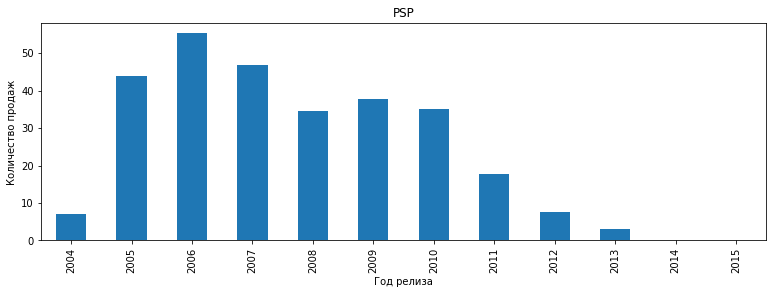

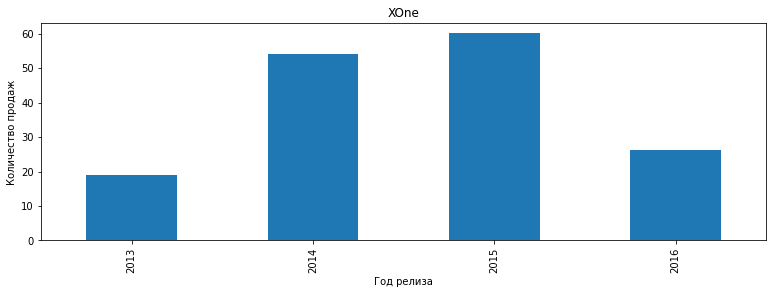

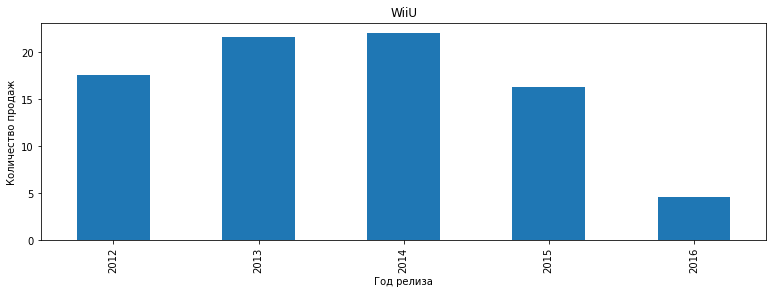

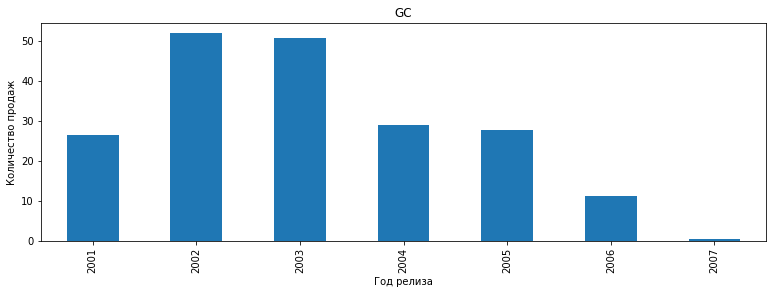

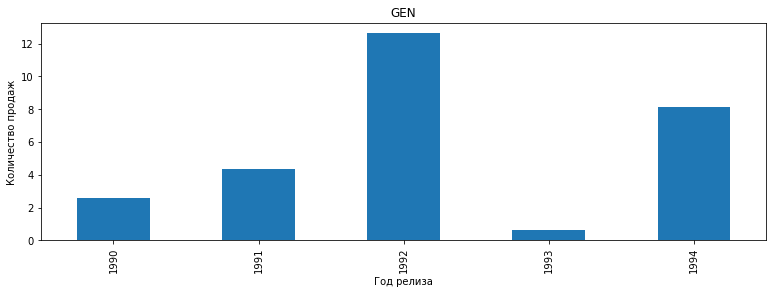

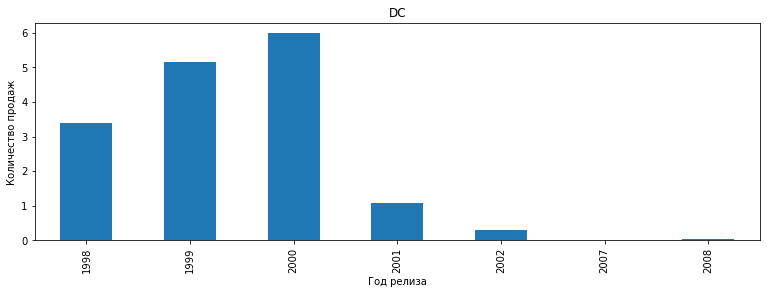

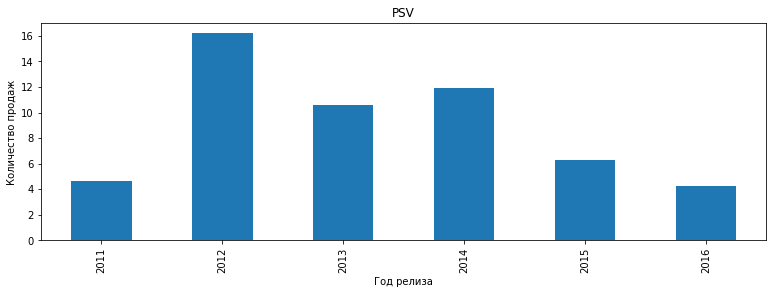

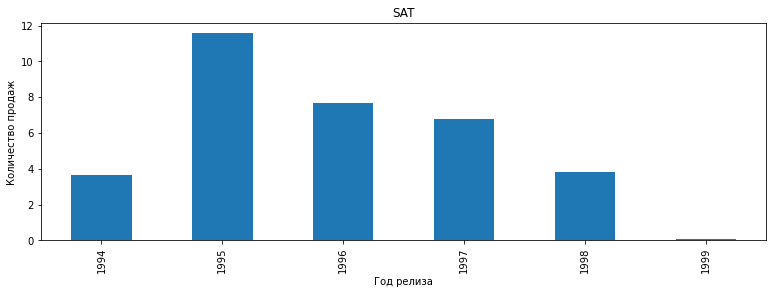

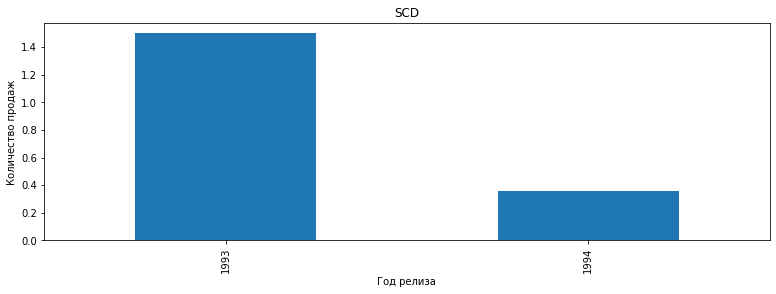

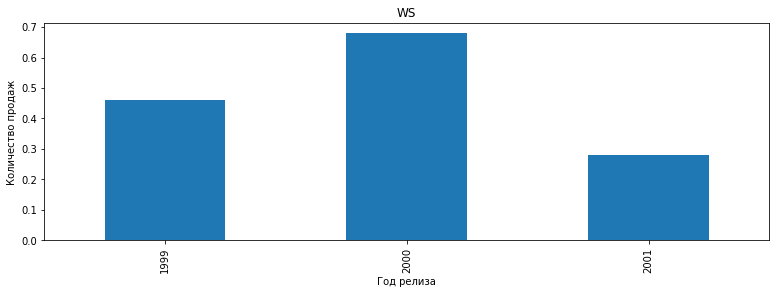

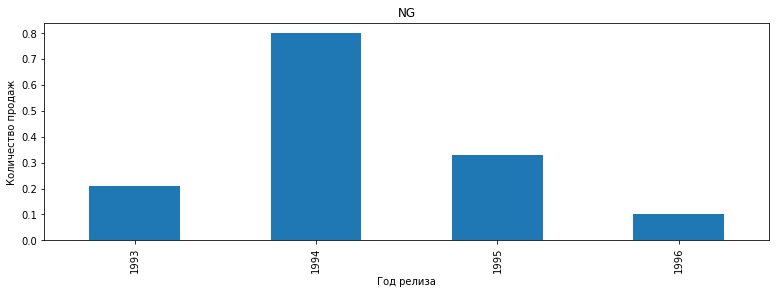

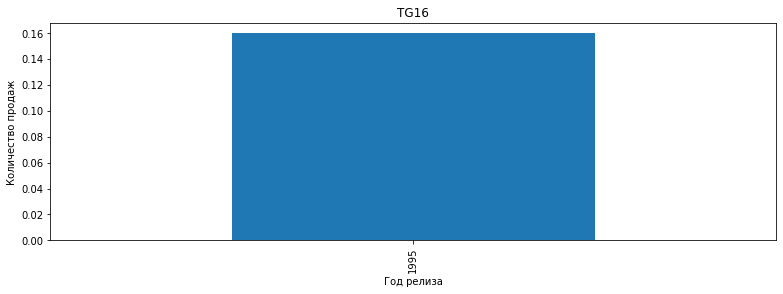

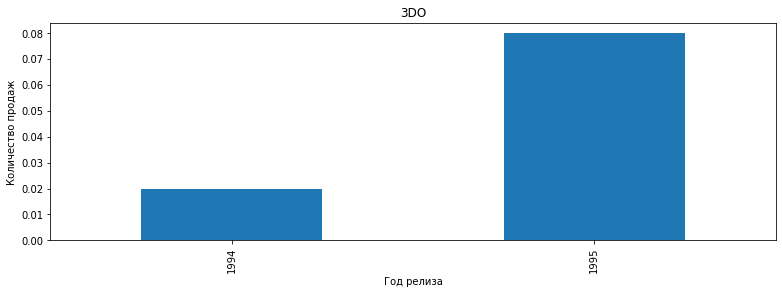

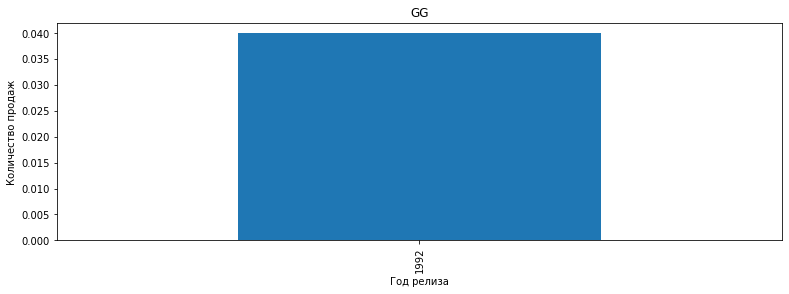

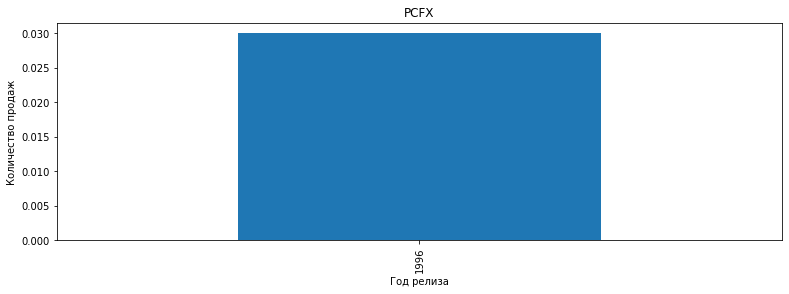

In [18]:
for platforma in platforms_list:
    games_data[games_data['platform'] == platforma].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(
        kind='bar', figsize=(13,4), legend=False)
    plt.xlabel("Год релиза")
    plt.ylabel("Количество продаж")
    plt.title(platforma)

Для большей части платформ характерный срок существования в среднем 8 - 10 лет. 
Также среди данных есть следующие закономерности:
- Когда выходит следующее поколение консолей, предыдущее теряет популярность. Это особенно ярко видно для платформы XB - она почти исчезает с 2006 года и примерно в это время появляется X360, далее на момент 2013 года уже для нее происходит спад, в это же время выходит "преемница" XOne, замещающая  старую модель. То же самое можно заметить в отношении ряда консолей SPS(PS, PS2, PS3, PS4, PSV). И для Nintendo (SNES, N64, GC DS, Wii, 3DS, WiiU).
- Самое долгое существование, ожидаемо, у PC, т.е. у компьютеров как игровой платформы. Компьютеры существуют давно и продолжают существовать, меняется только их "начинка". В то время, как иные платформы исчезают полностью, или же в силу выхода новых своих версий становятся менее популярными.
- Большая часть платформ на момент 2016 года уже прекратила свою работу.
- Лидирующие по продажам платформы ушли на спад еще до 2016 года.
- Рост, как правило, происходит не сразу, а спустя пару лет - это важно при прогнозировании продаж для новых платформ.

#### Определим **актуальный** период, за который нужно взять данные для дальнейшего исследования. Абсолютно точно, что совсем старые данные, до 2000 года не нужно брать. Ранее мы выясили, что срок существования платформы около 10 лет. Если смотреть на самые популярные за все годы платформы, то к моменту 2016 года их уже нет. То есть если брать период с примерно 2006 года - это слишком далеко от актуального периода для предположений на 2017 год.  Поэтому стоит посмотреть на данные примерно с 2013 года, т.е. четырёхлетний период. Это время, когда появились новые платформы, являющиеся более актуальными для прогнозов. 

In [19]:
actual_period_games = games_data.query('year_of_release > 2012')
actual_period_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,undefined,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,undefined,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,undefined,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,undefined,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,undefined,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,undefined,0.01


Построим теперь распределение продаж для каждой платформы по годам.

([<matplotlib.axis.XTick at 0x7efed4103d00>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

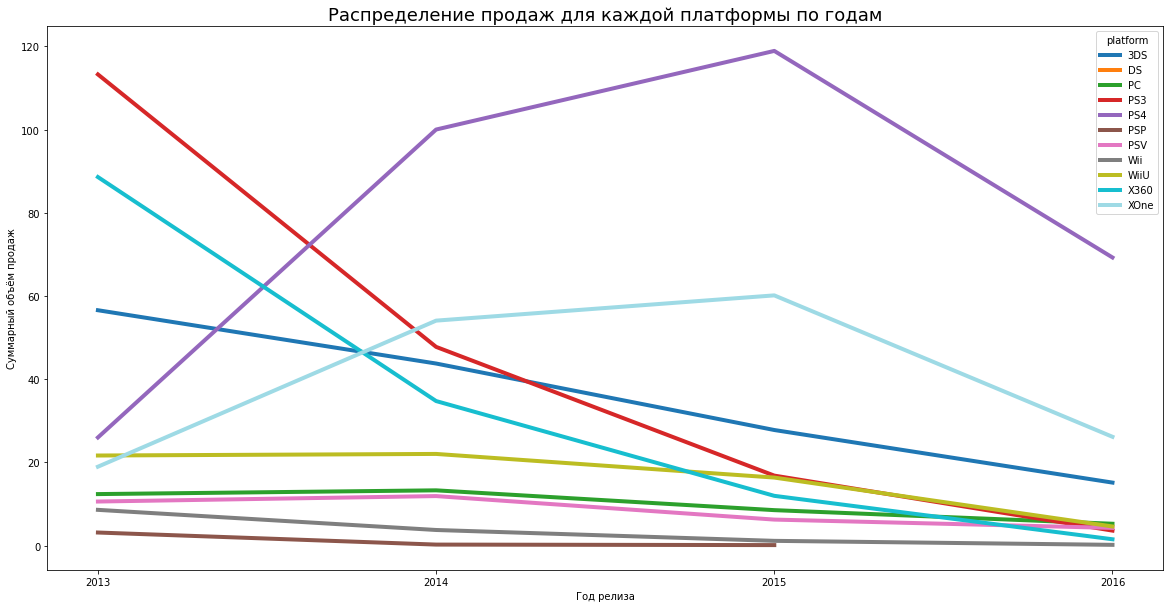

In [20]:
(
    actual_period_games
    .pivot_table(index='year_of_release', values='total_sales', columns='platform', aggfunc='sum') 
    .plot(xlabel='Год релиза', ylabel='Суммарный объём продаж', figsize=(20, 10), cmap='tab20', linewidth=4)
)
plt.title('Распределение продаж для каждой платформы по годам', fontsize=18)
plt.xticks([2013, 2014, 2015, 2016])

Не будем забывать, что данные за 2016 год неполные, а также то, что платформе нужно от нескольких до пяти лет, чтобы "разогреться" и достичь пика. На основе графика можем сделать вывод, какие платформы стоит далее исключить для актуального периода, а какие точно оставить. Уберем платформы, у которых виден особо сильный спад продаж - X360, PS3, Wii, PSP(пропадает в 2015 году после спада). 
Оставляем новые платформы, у них на графике спад в 2016 году, но помним, что данные просто не полны, и оставим те, где идут примерно одинаковые продажи. Т.е. рассматриваем XOne, PXV, 3DS, PC, WiiU, PS4. Соханим эти платформы в отдельный список. И оставим среди данных за актуальный период данные только для этих платформ.

In [21]:
top_platforms = ['XOne', 'PSV', '3DS', 'PC', 'WiiU', 'PS4']
top_platforms_games = actual_period_games.query('platform in @top_platforms')

top_platforms_games.groupby('platform')['total_sales'].describe() #посмотрим описание глобальных продаж для каждой платформы

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,303.0,0.472772,1.381347,0.01,0.04,0.09,0.280,14.60
PC,189.0,0.208624,0.352304,0.01,0.03,0.08,0.230,3.05
PS4,392.0,0.801378,1.609456,0.01,0.06,0.20,0.730,14.63
PSV,358.0,0.092151,0.153816,0.01,0.02,0.04,0.110,1.96
WiiU,115.0,0.562000,1.038778,0.01,0.06,0.20,0.595,7.09
XOne,247.0,0.645020,1.036139,0.01,0.06,0.22,0.685,7.39


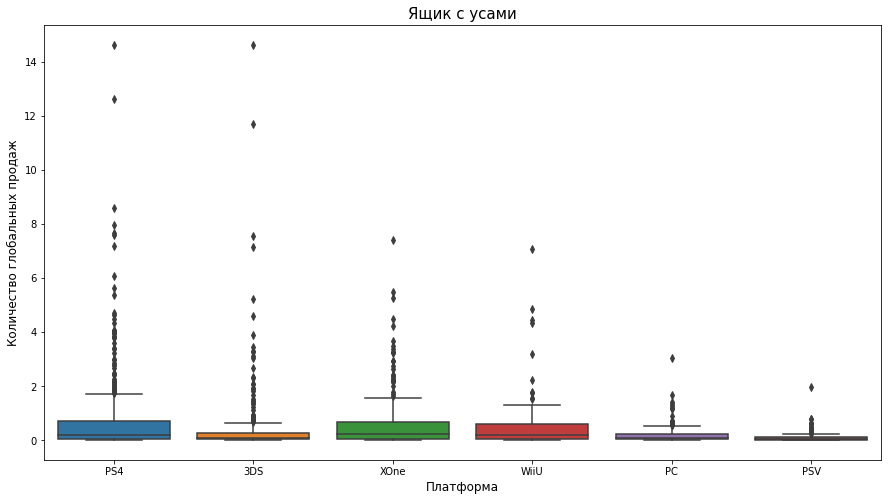

In [22]:
#Построим  «ящики с усами» по глобальным продажам игр в разбивке по 6 наиболее актуальным платформам
plt.figure(figsize=(15,8))
sns.boxplot(data=top_platforms_games, x='platform', y='total_sales')
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Количество глобальных продаж',fontsize=12)
plt.show()

Из таблицы и графиков видно, что у всех платформ разные средние значения, для PS4 и 3DS характерны сильные выбросы, которые, впрочем, удалять не стоит, так как это могут быть особо успешные игры и особо популярные платформы, действительно проданные в таких масштабах. 
Попробуем посмотреть на ящики поближе, изменив предельное значение оси продаж:

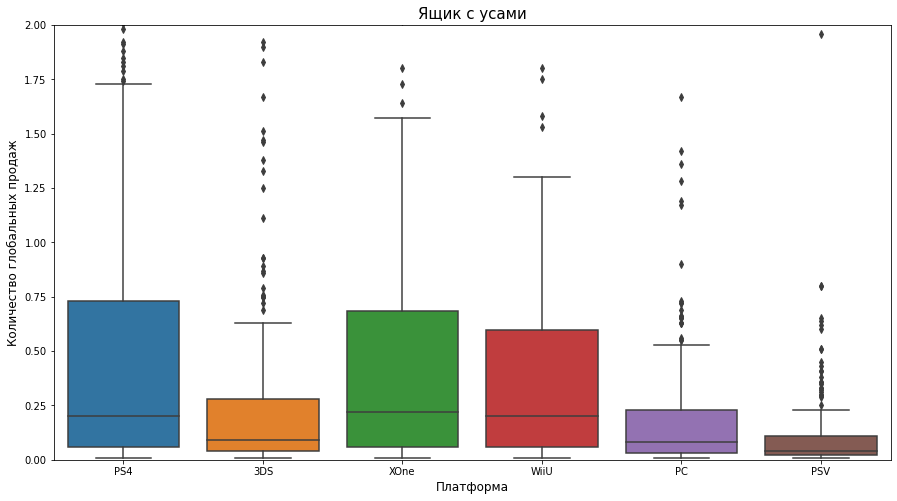

In [23]:
#Построим  «ящики с усами» по глобальным продажам игр в разбивке по 6 наиболее актуальным платформам
plt.figure(figsize=(15,8))
plt.ylim(0, 2)
sns.boxplot(data=top_platforms_games, x='platform', y='total_sales')
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Количество глобальных продаж',fontsize=12)
plt.show()

In [24]:
top_platforms_games.groupby('platform')['total_sales'].sum() #суммарное число продаж за период с 13 по 16 годы для каждой платформы

platform
3DS     143.25
PC       39.43
PS4     314.14
PSV      32.99
WiiU     64.63
XOne    159.32
Name: total_sales, dtype: float64

([<matplotlib.axis.XTick at 0x7efed40d7160>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

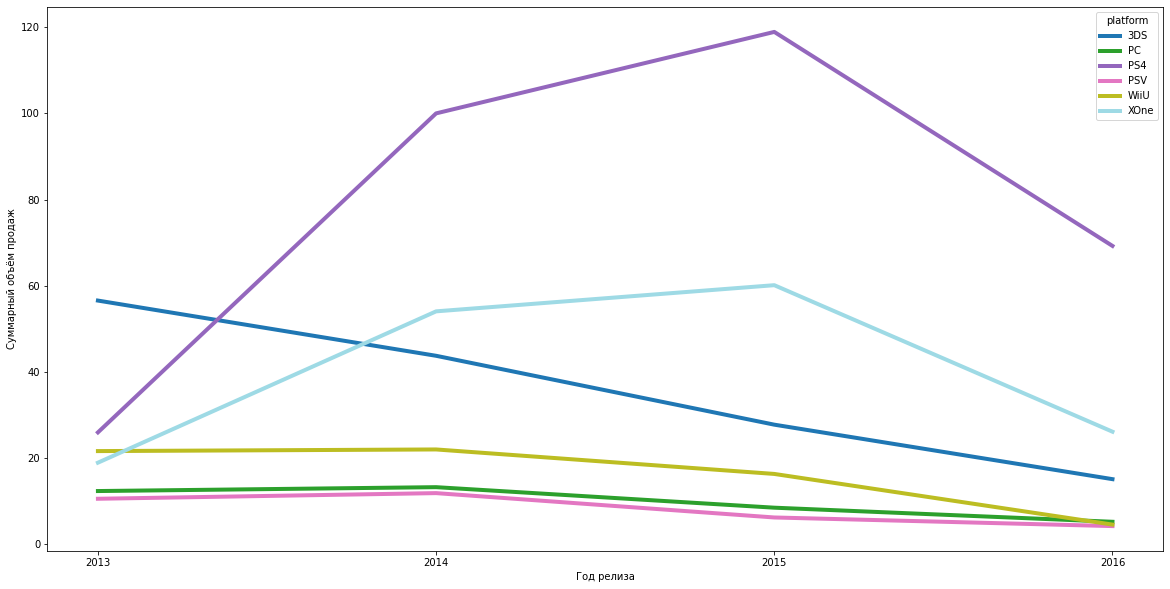

In [25]:
(
    top_platforms_games
    .pivot_table(index='year_of_release', values='total_sales', columns='platform', aggfunc='sum') 
    .plot(xlabel='Год релиза', ylabel='Суммарный объём продаж', figsize=(20, 10), cmap='tab20', linewidth=4)
)
plt.xticks([2013, 2014, 2015, 2016])

**Вывод:**

* Максимальное число продаж в период с 2013 года по 2016 получилось у PS4, затем идет XOne, и замыкает тройку лидеров 3DS. 
* Самый большой разброс суммарных продаж у PS4, XOne и WiiU. Это связано с тем, что и данные неполные за последний год, и и консоли новые, на начало их продаж прошлые поколения еще вполне нормально тянул игры и вообще функционировали. Спустя год - другой хочется уже видеть обновленную графику, новые возможности, больший выбор игр, поэтому скачкообразно люди переходят на новые. 
* Все данные скошены вправо.
* Если говорить о том, какие платформы будут потенциально прибыльными далее, у которых скорее всего будет рост, то это PS4, XOne. Это новые консоли, только набирающие популярность и при этом УЖЕ набравшие максимально число продаж за актуальный период среди всех платформ.
* Компьютерные игры (платформа PC) стоят скорее всего дешевле приставочных, плюс приставки более удобны для игр, поэтому на ПК примерно ровная линия, роста ожидать не следует.


#### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами

Возьмем платформу PS4, т.к. у нее самые высокие продажи в 2016 году, она новая и саммарно уже обогнала остальные за выбранный нами ранее период.

In [26]:
sps4 = actual_period_games.query('platform == "PS4"')
sps4['user_score'].corr(sps4['total_sales'])

-0.031957110204556376

In [27]:
sps4['critic_score'].corr(sps4['total_sales'])

0.40656790206178095

<AxesSubplot:xlabel='user_score', ylabel='total_sales'>

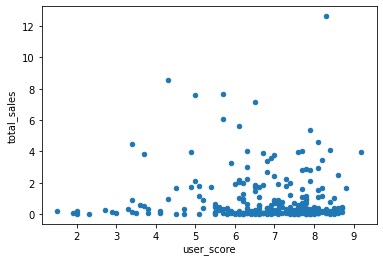

In [28]:
sps4.plot(kind='scatter', x='user_score', y='total_sales')

<AxesSubplot:xlabel='critic_score', ylabel='total_sales'>

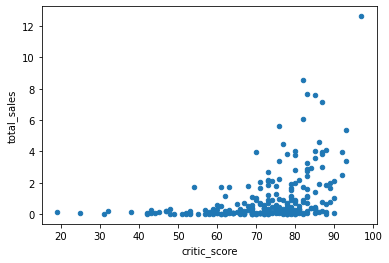

In [29]:
sps4.plot(kind='scatter', x='critic_score', y='total_sales')

По диаграммам рассеяния и вычисленным коэффициентам корреляции Пирсона делаем вывод, что корреляция слабая. Между оценкой пользователей и продажами её почти нет. И есть слабая между оценкой критиков и продажами. 
Это может быть следствием того, что в столбцах с оценками много пропусков, а может из-за новизны платформы - все просто хотят нового, не опираясь на оценки.

In [30]:
#Напишем функцию, которая будет отрисовывать графики рассеивания и считать корреляции
def other_platform_matrix(name_of_platform):
    platform = actual_period_games[games_data['platform']==name_of_platform]
    fig, ax = plt.subplots(1 ,2, figsize=(15,5))
    sns.scatterplot(x='user_score', y='total_sales', data=platform, ax=ax[0])
    sns.scatterplot(x='critic_score', y='total_sales', data=platform, ax=ax[1])
    fig.suptitle(name_of_platform, fontsize=15)
    ax[0].set(xlabel='Оценка пользователей')
    ax[1].set(xlabel='Оценка критиков')
    ax[0].set(ylabel='Количество продаж')
    ax[1].set(ylabel='Количество продаж')
    plt.show()
    
    correl = platform['user_score'].corr(platform['total_sales'])
    critic_correl = platform['critic_score'].corr(platform['total_sales'])
    
    
    if 0.3 >= critic_correl >= 0.1:
        print(f'Корреляция между отзывами критиков и продажами для {name_of_platform}, очень слабая:', critic_correl)
    if 0.5 >= critic_correl >= 0.3:
        print(f'Корреляция между отзывами критиков и продажами для {name_of_platform}, слабая:', critic_correl)
    if 0.7 >= critic_correl >= 0.5:
        print(f'Корреляция между отзывами критиков и продажами для {name_of_platform}, средняя:', critic_correl)
    if 0.9 >= critic_correl >= 0.7:
        print(f'Корреляция между отзывами критиков и продажами для {name_of_platform}, сильная:', critic_correl)
    if 1 >= critic_correl >= 0.9:
        print(f'Корреляция между отзывами критиков и продажами для {name_of_platform}, очень сильная:', critic_correl)
    
    if 0.3 >= correl >= 0.1:
        print(f'Корреляция между отзывами пользователей и продажами для {name_of_platform} очень слабая:', correl)
    if 0.5 >= correl >= 0.3:
        print(f'Корреляция между отзывами пользователей и продажами для {name_of_platform} слабая:', correl)
    if 0.7 >= correl >= 0.5:
        print(f'Корреляция между отзывами пользователей и продажами для {name_of_platform} средняя:', correl)
    if 0.9 >= correl >= 0.7:
        print(f'Корреляция между отзывами пользователей и продажами для {name_of_platform} сильная:', correl)
    if 1 >= correl >= 0.9:
        print(f'Корреляция между отзывами пользователей и продажами для {name_of_platform} очень сильная:', correl)
    
    
    if 0.1 >= correl >= -0.1:
        print(f'Корреляции между отзывами пользователей и продажами для {name_of_platform} нет:', correl)
    if -0.1 >= correl >= -0.3:
        print(f'Корреляция между отзывами пользователей и продажами  для {name_of_platform} очень слабая обратная:', correl)
    if -0.3 >= correl >= -0.5:
        print(f'Корреляция между отзывами пользователей и продажами для {name_of_platform} слабая обратная:', correl)
    if -0.5 >= correl >= -0.7:
        print(f'Корреляция между отзывами пользователей и продажами для {name_of_platform} средняя обратная:', correl)
    if -0.7 >= correl >= -0.9:
        print(f'Корреляция между отзывами пользователей и продажами для {name_of_platform} сильная обратная:', correl)
    if -0.9 >= correl >= -1:
        print(f'Корреляция между отзывами пользователей и продажами  для {name_of_platform} очень сильная обратная:', correl)
  

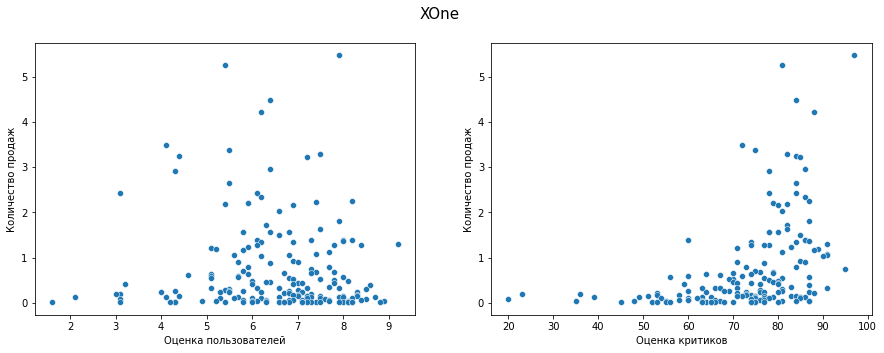

Корреляция между отзывами критиков и продажами для XOne, слабая: 0.4169983280084017
Корреляции между отзывами пользователей и продажами для XOne нет: -0.06892505328279414


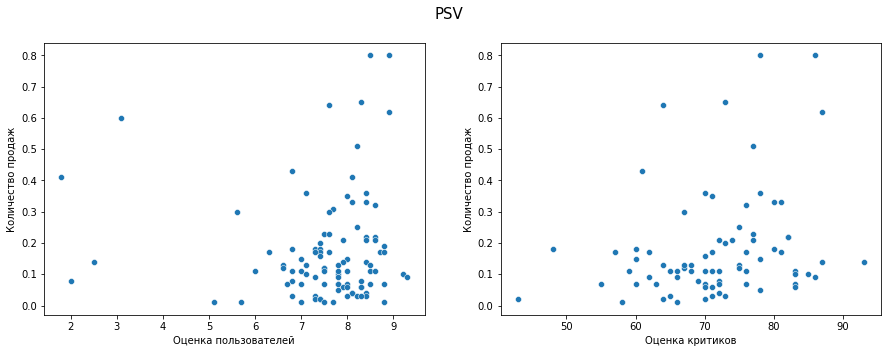

Корреляция между отзывами критиков и продажами для PSV, очень слабая: 0.2547423503068656
Корреляции между отзывами пользователей и продажами для PSV нет: 0.0009424723319108626


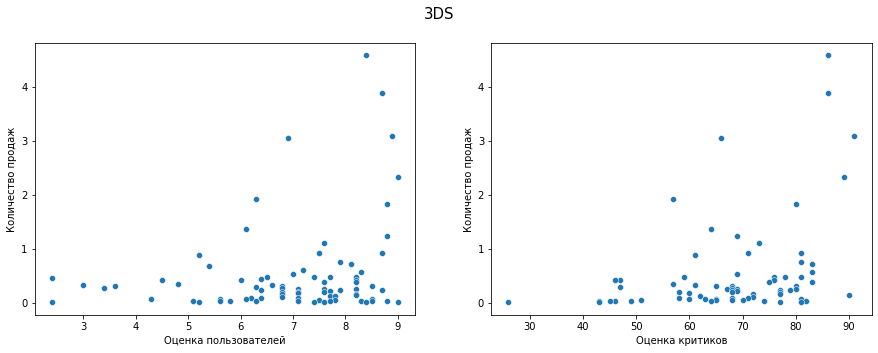

Корреляция между отзывами критиков и продажами для 3DS, слабая: 0.3570566142288103
Корреляция между отзывами пользователей и продажами для 3DS очень слабая: 0.24150411773563016


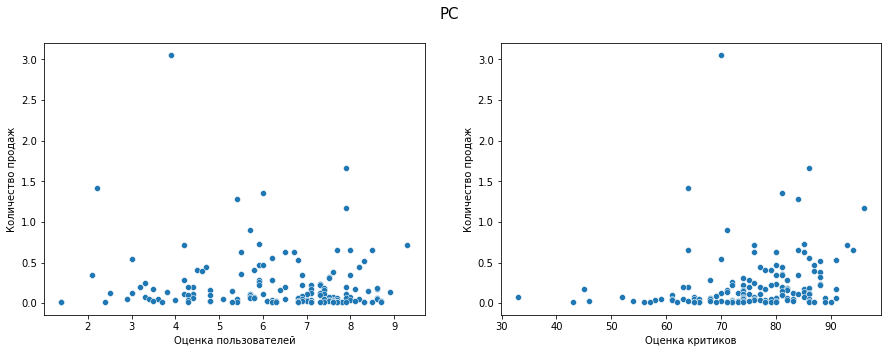

Корреляция между отзывами критиков и продажами для PC, очень слабая: 0.19603028294369382
Корреляции между отзывами пользователей и продажами для PC нет: -0.0938418695247674


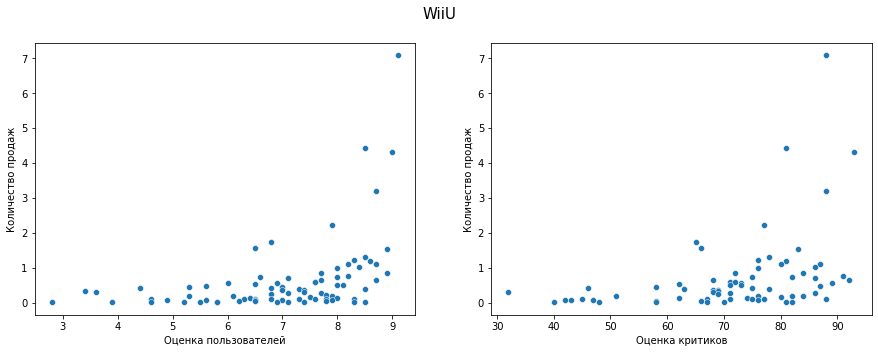

Корреляция между отзывами критиков и продажами для WiiU, слабая: 0.3764149065423912
Корреляция между отзывами пользователей и продажами для WiiU слабая: 0.4193304819266187


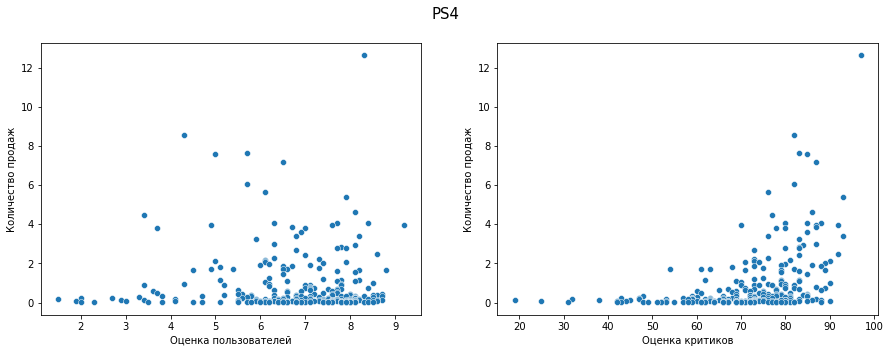

Корреляция между отзывами критиков и продажами для PS4, слабая: 0.40656790206178095
Корреляции между отзывами пользователей и продажами для PS4 нет: -0.031957110204556376


In [31]:
for platforma in top_platforms:
    other_platform_matrix(platforma)

Для всех отобранных платформ корреляция продаж с оценками критиков слабая. И вовсе отсутствует для продаж и оценок пользователей. Это говорит о том, что пусть и не сильно, но люди прислушиваются к критикам, нежели к остальным пользователям.

#### Посмотрим на общее распределение игр по жанрам. Рассмотрим самые прибыльные жанры и выделяются ли жанры с высокими и низкими продажами.

In [32]:
genre_games = top_platforms_games.pivot_table(index='genre', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
genre_games

,total_sales
genre,
Action,199.18
Shooter,165.71
Role-Playing,123.94
Sports,90.67
Misc,34.66
Platform,34.22
Racing,30.36
Fighting,26.69
Simulation,19.81


Судя по таблице, больше всего покупаются игры жанров Action, Shooter и Role-Playing. Они скорее всего дороже, так как там очень важны графика, сюжет, и более широко представлены.
Посмотрим, сколько вообще игр каждого жанра:

In [33]:
top_platforms_games.groupby('genre')['name'].count()

genre
Action          568
Adventure       169
Fighting         48
Misc            112
Platform         55
Puzzle           16
Racing           60
Role-Playing    228
Shooter         122
Simulation       50
Sports          127
Strategy         49
Name: name, dtype: int64

Да, игр жанра Action больше всего, Role-Playing на 2м месте по количеству, стрелялок тоже много. 

Text(0, 0.5, 'Прибыль')

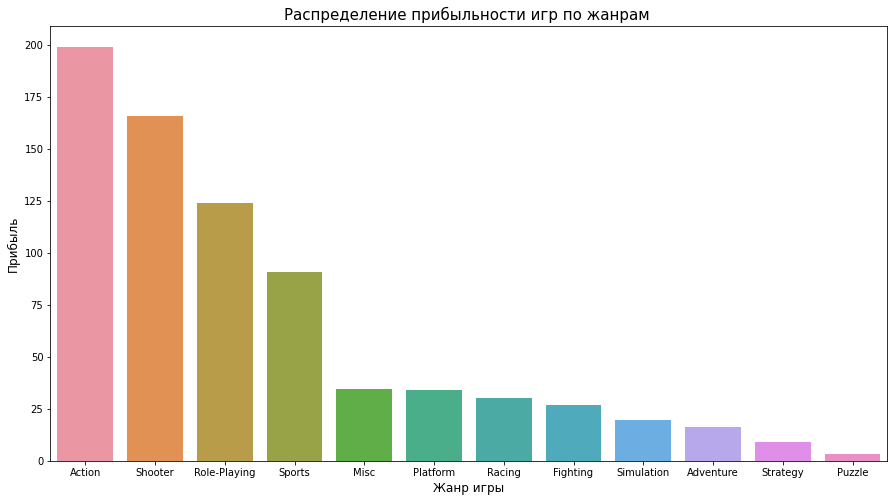

In [34]:
#Изобразим график продаж по жанрам для наглядности

plt.figure(figsize=(15,8))
plt.title('Распределение прибыльности игр по жанрам ',fontsize=15)
sns.barplot(data=genre_games.reset_index(), x='genre', y='total_sales')
plt.xlabel('Жанр игры',fontsize=12)
plt.ylabel('Прибыль',fontsize=12)

Однозначно из жанров с высокими продажами сильно выделяются, как уже было сказано выше, Action, Shooter, Role-Playing. Аутсайдер - игры жанра Puzzle, что ожидаемо - они скучные, да и стоят дешево из-за легкости производства, нет графики крутой, сюжета.
Удивительно, но при большом числе игр жанра Adventure, их прибыльность почти на последнем месте.

**Выводы по исследовательскому анализу:**
- Количество компьютерных игр (консольных и для ПК) сильно росло начиная с 90х годов до 2008 года, когда был достигнут пик. С 2008 года происходит переход пользователей на мобильные устройства и далее на смартфоны - игры теперь появляются там, как и соц.сети, ззаменяющие такое развлечение, как игры.
- За все время существования игр самыми популярными и прибыльными стали следующие платформы: PS2, X360, PS3, Wii, DS и PS.
- Почти любая платформа от момента появления, до "заката" существует не более 10 лет.
- Люди чаще опираются на оценку критиков при покупке игры, нежели на оценку таких же пользователей. Об этом говорит пусть и слабая, но все же связь оценки критиков и суммарной прибыли. И практическое отсутствие связи с оценкой игроков.
- За последние 6 лет самым распространенным и прибыльным жанром является Action, и наоборот - самый малоприбыльный и малопредставленный играми - Puzzle.

### Портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):
* самые популярные платформы (топ-5) и различия в долях продаж,
* самые популярные жанры (топ-5)
* влияет ли рейтинг ESRB на продажи в отдельном регионе.

In [35]:
#функция для построения графиков топ-5 платформ по продажам для каждого региона
def top_5_region_platform(platforma, region_sales, ax):
    table = actual_period_games.groupby(platforma).agg({region_sales: 'sum'}).sort_values(by=region_sales, ascending=False).head(5)
    title_dict = {'na_sales': 'North America Sales', 'eu_sales': 'Europe Sales', 'jp_sales': 'Japan Sales'}
    plot = table.plot(kind='bar', ax=axes[ax], fontsize=18, title=title_dict[region_sales], legend=False)
    plot.title.set_size(20)

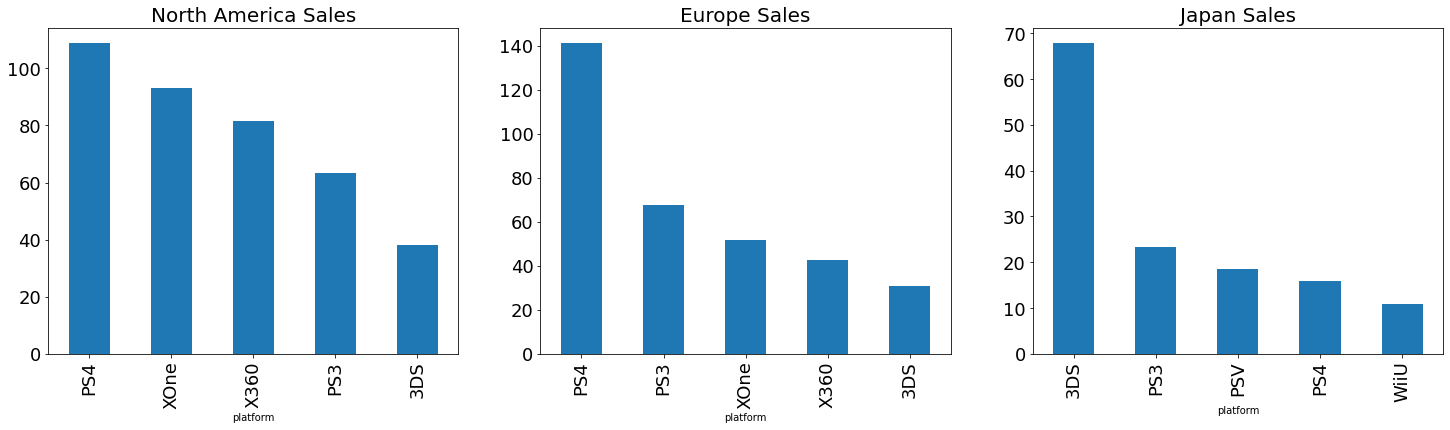

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_5_region_platform('platform', 'na_sales', 0)
top_5_region_platform('platform', 'eu_sales', 1)
top_5_region_platform('platform', 'jp_sales', 2)

**Топ-5 платформ за всё время:**
* В Северной Америке: PS4, XOne, X360, PS3, 3DS.
* В Европе: PS4, PS3, XOne, X360, 3DS.
* В Японии: 3DS, PS3, PSV, PS4, WiiU.

Если смотеть по самой популярной платформе, то в Северной Америке продажи почти в 2 раза выше по сравнению с Японией, а Европа имеет еще большие продажи для лидирующей платформы и также предпочитают PS4, как и Американские пользователи. 

In [37]:
#функция для построения графиков топ-5 жанров по продажам для каждого региона
def top_5_region_genre(genre, region_sales, ax):
    table = actual_period_games.groupby(genre).agg({region_sales: 'sum'}).sort_values(by=region_sales, ascending=False).head(5)
    title_dict = {'na_sales': 'North America Sales', 'eu_sales': 'Europe Sales', 'jp_sales': 'Japan Sales'}
    plot = table.plot(kind='bar', ax=axes[ax], fontsize=18, title=title_dict[region_sales], legend=False)
    plot.title.set_size(20)

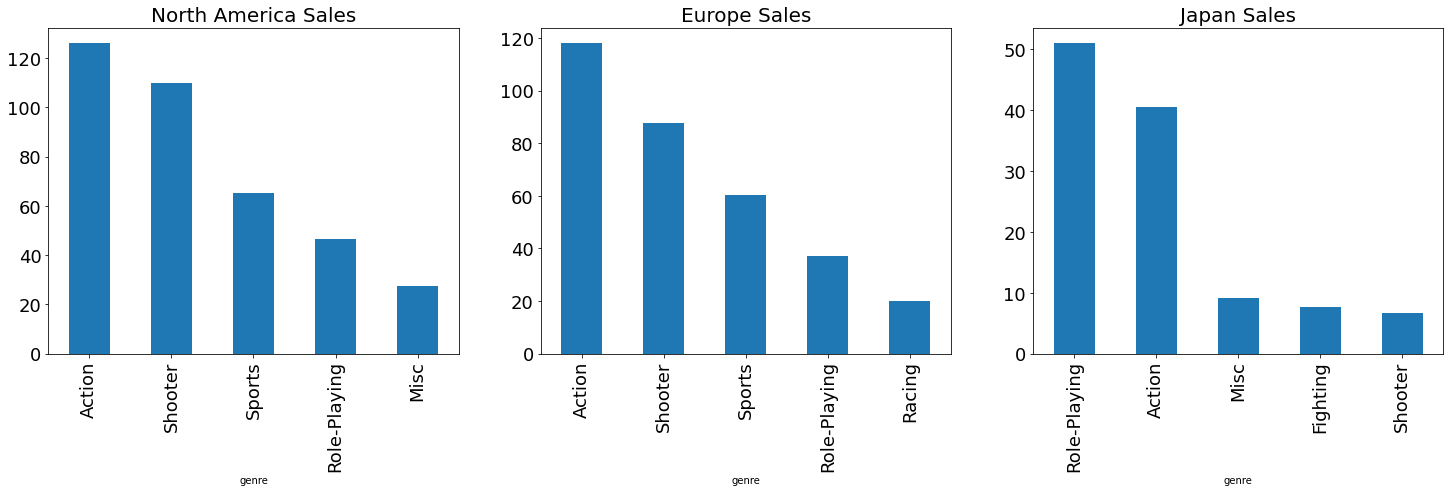

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))
top_5_region_genre('genre', 'na_sales', 0)
top_5_region_genre('genre', 'eu_sales', 1)
top_5_region_genre('genre', 'jp_sales', 2)

С жанрами картини не так сильно отличаются друг от друга. В Америке и Европе больше всего любят Action, в Японии этот жанр на 2 месте. В остальном фавориты одни и те же практически - Sports, Shooter, Platform, Misc. В Японии самый топовый жанр - Role-Playing, также примечательно, что в Японии в топе не представлен жанр Shooter, спокойный восточный менталитет :)  

In [39]:
#функция для построения графиков влияния рейтинга на продажи для каждого региона
def rating_in_region(rating, region_sales, ax):
    table = actual_period_games.groupby(rating).agg({region_sales: 'sum'}).sort_values(by=region_sales, ascending=False).head(5)
    title_dict = {'na_sales': 'North America Sales', 'eu_sales': 'Europe Sales', 'jp_sales': 'Japan Sales'}
    plot = table.plot(kind='bar', ax=axes[ax], fontsize=18, title=title_dict[region_sales], legend=False)
    plot.title.set_size(20)

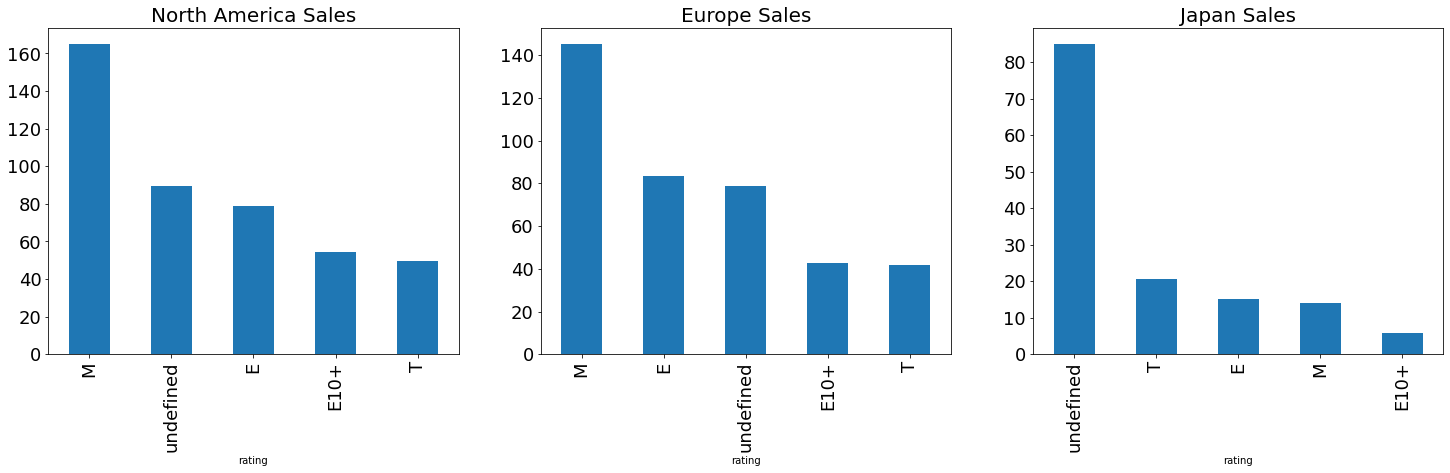

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))
rating_in_region('rating', 'na_sales', 0)
rating_in_region('rating', 'eu_sales', 1)
rating_in_region('rating', 'jp_sales', 2)

Распишем, что означает каждый рейтинг в системе ESRB:
* E - Подходит для всех возрастных категорий. 
* M - Подходит для лиц старше 17 лет.
* T - Подходит для лиц старше 13 лет. 
* E10+ - Подходит для лиц старше 10 лет. 

Как видим, в Америке и Европе большая часть покупаемых игр из категории "Старше 17-ти". В остальном у "запада" картинка схожая.
В Японии больше всего игр с неустановленным рейтингом, что может быть связано с тем, что ESRB - американская организация, устанавливающая рейтинг. 
Ну а в принципе игры из иных категорий рейтинговых (они есть) покупаются во всех 3 регионах меньше этих пяти.

### Проверка гипотез

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Установим пороговое значение alpha равным 0.05.

Итак, первая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**Н₀(нулевая гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

**H₁(альтернативная гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC отличаются** (двусторонняя гипотеза)

Для проверки этой гипотезы будем исспользовать метод ttest_ind(), он проверяет равенство среднего двух ген.совокупностей по всятым из них выборкам. Также выберем актуальный период, так как XOne появилась в 2013 году только и сравнивать ее данные с PC, у которого период с 1992 года - не корректно. Выберем актуальный период - с 2013 года, с момента появления XOne. 

In [41]:
xone = games_data[(games_data['platform']=="XOne") & (games_data['year_of_release']>2012)]['user_score'].dropna() # Оценки для XOne с удалёнными пропусками(они сделают среднее некорректным)
pc =  games_data[(games_data['platform']=="PC") & (games_data['year_of_release']>2012)]['user_score'].dropna() # аналогично для PC
alpha = 0.05 #критический уровень стат.значимости
result1 = st.ttest_ind(xone, pc, equal_var=False)
print('p-значение:', result1.pvalue)
if result1.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


In [42]:
#посмотрим, на то, какие средние рейтинги для каждой из этих платформ
xone_mean = xone.mean() 
pc_mean =  pc.mean()
xone_mean, pc_mean

(6.521428571428572, 6.2696774193548395)

Итак, можно говорить о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, так как опровергнуть нулевую гипотезу не получилось. Зачение p-value получилось равным примерно 14.8% при уровне значимости в 5%.  

Вторая гипотеза: средние пользовательские рейтинги жанров Action и Sports разные.

**Н₀(нулевая гипотеза) - средние пользовательские рейтинги жанров Action и Sports одинаковые**(нулевая гипотеза всегда строится на равенстве)

**H₁(альтернативная гипотеза) - средние пользовательские рейтинги жанров Action и Sports отличаются** (двусторонняя гипотеза)

Для проверки этой гипотезы также будем исспользовать метод ttest_ind(). И также выберем актуальный период, в этот раз он может быть шире, т.к. нет ограничений в виде появления жанра в каком-то году. Сделаем его равным 10 годам.

In [43]:
genre_action = games_data[(games_data['genre']=='Action') & (games_data['year_of_release']>2006)]['user_score'].dropna()
genre_sports = games_data[(games_data['genre']=='Sports') & (games_data['year_of_release']>2006)]['user_score'].dropna()

alpha = 0.05 
result2 = st.ttest_ind(genre_action, genre_sports, equal_var=False)
print('p-значение:', result2.pvalue)
if result2.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.540665510055229e-11
Отвергаем нулевую гипотезу


In [44]:
genre_action_mean = genre_action.mean()
genre_sports_mean = genre_sports.mean()
genre_action_mean, genre_sports_mean

(6.836079077429983, 6.307979626485569)

Отвергаем нулевую гипотезу, т.к. p-value сильно меньше уровня значимости. Т.е. средние пользовательские рейтинги жанров Action и Sports отличаются. 

**Вывод:**
- Проверили две гипотезы.
- Первая гипотеза была о равенстве средних пользовательских рейтингов платформ Xbox One и PC. Нулева гипотеза НЕ опровергнута. 
- Вторая гипотеза: средние пользовательские рейтинги жанров Action и Sports разные. Тут нулевая гипотеза была сформулирована равенством рейтингов. Гипотеза нулевая была опровергнута.
- Обе гипотезы проверялись методом для проверки о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.

# ОБЩИЕ ВЫВОДЫ

1. Перед анализом изучили данные и произвели их предобработку. Предобработка включала в себя работу с пропусками и приведение столбцов к корректным типам данных. Незначительная часть строк с пропусками, которые было невозможно обработать, была удалена. В столбце `user_score` обнаружили значения 'tbd', данные не были заполнены не случайно, эти значения для возможности дальнейшей обработки заменили на Nan. Пропуски в рейтинге от организации ESRB заменили на 'undefined'(не определено), так как заполнять иначе их было бы некорректно, а пропусков довольно много для удаления строк. Также создали новый столбец с суммой продаж по всем регионам.

2. Далее призвели исследовательский анализ полученных данных. 

Количество игр сильно росло с 90х годов до 2008 года, где был достигнут пик. С 2008 года происходит переход пользователей на мобильные устройства и далее на смартфоны - игры теперь появляются там, как и соц.сети, во многом заменяющие игры. 
За все время существования игр самыми популярными и прибыльными стали следующие платформы: PS2, X360, PS3, Wii, DS и PS.
Почти любая платформа от момента появления, до "заката" существует не более 10 лет.
Люди чаще опираются на оценку критиков при покупке игры, нежели на оценку таких же пользователей.
За последние 6 лет самым распространенным и прибыльным жанром является Action, и наоборот - самый малоприбыльный и малопредставленный играми - Puzzle.

3. Составили портрет пользователей каждого из представленных регионов. 

Так в Северной Америке самыми популярными являются платформы: PS4, XOne, X360, PS3, 3DS.
В Европе: PS4, PS3, XOne, X360, 3DS.
В Японии: 3DS, PS3, PSV, PS4, WiiU.
В Америке и Европе больше всего любят Action, в Японии этот жанр на 2 месте. В остальном фавориты одни и те же практически - Sports, Shooter, Platform, Misc. В Японии самый топовый жанр - Role-Playing. А рейтинг наиболее покупаемых игр практически везде одинаковый.

4. В результата статистического анализа проверили 2 гипотезы. Одна из них была отвергнута, другая нет. Первая гипотеза была о равенстве средних пользовательских рейтингов платформ Xbox One и PC. Нулева гипотеза НЕ опровергнута.
Вторая гипотеза: средние пользовательские рейтинги жанров Action и Sports разные. Тут нулевая гипотеза была сформулирована равенством рейтингов. Гипотеза нулевая была опровергнута.

**Для прогноза будущих продаж стоит обращать внимание на как можно более свежие данные, примерно за последние 2-3 года, так как технологии сейчас быстро совершенствуются, интересы людей тоже меняются, появляются новые тренды. Стоит больше обращать внимание на игры жанров Action, Shooter и Role-Playing, так как они стали самыми прибыльными и в целом, и в каждом из регионов. Также наиболее покупаемы игры с рейтингом "для всех возрастных категорий". А если смотеть на самую потенциально прибыльную платформу, то это новые, набирающие популярность PS4 и XOne.**